# Select patient with valid data for selected signal sources
- sao2, 
- heartrate, 
- respiration, 
- systemicsystolic, 
- systemicdiastolic, 
- systemicmean
- netto input-output volume (io_nettotal)
- urine volume

In [1]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import icd10
from icd9cms.icd9 import search

from collections import Counter

from utils.data_io import *
from utils.common import *

In [ ]:
database_folder_path = '/media/kai/Shared Space/database-ICU/eICU/all'

vitals_selected = ['sao2', 'heartrate', 'respiration', 'systemicsystolic', 'systemicdiastolic', 'systemicmean']
entry_name = 'Urine'
entry = 'celllabel'
entry_group = 'intakeoutput'

pid_arf = []
pid_arf_valid = []

for filename in os.listdir(database_folder_path):
    data = json.load(open(database_folder_path+filename))
    if len(data['diagnosis']['diagnosisoffset']) > 0:
        is_arf = False
        for diagnosisstr in data['diagnosis']['diagnosisstring']:
            if 'acute renal failure' in diagnosisstr:
                pid_arf.append(data['patient']['patientunitstayid'][0])
                is_arf = True
                break
        if is_arf:
            io_nettotal = data['intakeoutput']['nettotal']
            subset_idx = select_entry_subset(data, entry_group, entry, entry_name)
            urine = select_list_subset_with_index(data[entry_group]['cellvaluenumeric'], subset_idx)

            if valid_data_length(io_nettotal) == 0:
                continue
            if len(urine) == 0:
                continue
            for vital in vitals_selected:
                if valid_data_length(data['vitalperiodic'][vital]) == 0:
                    continue
            pid_arf_valid.append(pid)
                           
np.save('processed/acute_renal_failure/pid_acute_renal_failure', pid_arf)
np.save('processed/acute_renal_failure/pid_acute_renal_failure_valid', pid_arf_valid)

# Check ICD code for patient with ARF diagnosis

In [2]:
pid_acute_renal_failure = np.load('processed/acute_renal_failure/pid_acute_renal_failure_valid.npy')

icd_code = {}
for pid in pid_acute_renal_failure:
    data = load_patient_data_by_id(pid)
    dx = data['diagnosis']['diagnosisstring']
    icds = data['diagnosis']['icd9code']
    for d, icd in zip(dx, icds):
        if 'acute renal failure' in d:
            if icd not in icd_code:
                icd_code[icd] = [d]
            else:
                icd_code[icd].append(d)

In [ ]:
icd_code_count = {}
for icd in icd_code:
    count = Counter(icd_code[icd])
    icd_code_count[icd] = {k:v for k,v in sorted(count.items(), key=lambda item: item[1], reverse=True)}

In [15]:
for k in icd_code_count.keys():
    print(f'{k}: {sum(icd_code_count[k].values())}')

584.9, N17.9: 15428
038.9, 584.9, R65.20, N17: 393
: 147
599.60, N17.9: 106
584.5, N17.0: 484
572.4, K76.7: 45
584.9, E942.9, N17.9: 20
584.9, E947.8, N17.9: 27
584.9, E935.3, N17.9: 23


In [46]:
for icd in icd_code_count:
    print(f'{icd}:')
    for dx in icd_code_count[icd]:
        print(f'\t{dx}: {icd_code_count[icd][dx]}')

584.9, N17.9:
	renal|disorder of kidney|acute renal failure: 13032
	renal|disorder of kidney|acute renal failure|due to hypovolemia/decreased circulating volume: 932
	renal|disorder of kidney|acute renal failure|due to sepsis: 578
	renal|disorder of kidney|acute renal failure|etiology unknown: 278
	renal|disorder of kidney|acute renal failure|due to rhabdomyolysis: 260
	renal|disorder of kidney|acute renal failure|due to renal ischemia: 175
	renal|disorder of kidney|acute renal failure|due to nephrotoxic agents: 58
	renal|disorder of kidney|acute renal failure|unstable during hemodialysis: 33
	renal|disorder of kidney|acute renal failure|due to interstitial nephritis from drugs: 29
	surgery|renal issues|acute renal failure: 14
	renal|disorder of kidney|acute renal failure|due to cardio-pulmonary bypass: 12
	renal|disorder of kidney|acute renal failure|due to nephrotoxic agents|hemolysis: 12
	renal|disorder of kidney|acute renal failure|due to nephrotoxic agents|rhabdomyolysis: 5
	surge

# Save patient with diagnosis code "584.9, N17.9"

In [8]:
pid_5849 = {}
for pid in pid_acute_renal_failure:
    data = load_patient_data_by_id(pid)
    icds = data['diagnosis']['icd9code'] 
    timestamps = data['diagnosis']['diagnosisoffset']
    priority = data['diagnosis']['diagnosispriority']
    for icd, ts, prior in zip(icds, timestamps, priority):
        if icd == '584.9, N17.9':
            if pid in pid_5849:
                pid_5849[pid].append([ts, prior])
            else:
                pid_5849[pid] = [ts, prior]

In [9]:
np.save('processed/acute_renal_failure/pid_5849', list(pid_5849.keys()))

# Analyse patient data 6h before the ARF event

In [2]:
SELECTED_SIGNALS = [
    # vitals
    'heartrate', 'respiration', 'sao2',
    'systemicsystolic', #'systemicdiastolic', 'systemicmean', 
    # intake & output
    'nettotal', 'Urine', #'intaketotal', 'outputtotal', 
    # lab test
    'BUN', 'creatinine', #'urinary sodium', 'urinary osmolality'
    #'bedside glucose', 'potassium', 'sodium', 'Hgb', 'chloride',
]

SIGNAL_WINDOW_SIZE = {
    #UNIT: MIN
    'heartrate': 360, 
    'respiration': 360, 
    'sao2': 360,
    'systemicsystolic': 360,
    'nettotal': 1440, 
    'Urine': 1440,
    'BUN': 1440, 
    'creatinine': 1440,
}

uid_dict = np.load('processed_dataset/uid_dictionary.npy', allow_pickle=True).item()
uid2str_dict = {v:k for k,v in uid_dict.items()}

dx_target = '584.9, N17.9'
dx_target_uid = uid_dict[dx_target]


pid_5849 = np.load('processed/acute_renal_failure/pid_5849.npy')

In [3]:
for sig in SELECTED_SIGNALS:
    print(sig, ': ', uid_dict[sig])

heartrate :  100002
respiration :  100003
sao2 :  100004
systemicsystolic :  100007
nettotal :  300004
Urine :  300017
BUN :  400031
creatinine :  400006


In [4]:
# Check if a measurement/signal exist in patient data during the time window before the target diagnosis event
def sig_exist(sig_uid, data:pd.DataFrame, t_dx, window_size=1440):
    # sig_uid: unique ID of signal source (see DatasetOverview)
    # data: preprocessed patient data
    # t_dx: event time of the target diagnosis
    # window_size: time window before the target diagnosis
    sig_data = data[data['UID']==sig_uid]
    if sig_data.shape[0] == 0:
        return sig_data
    
    sig_data_before_event = sig_data[
        (sig_data['Offset'] > 0)
        & (sig_data['Offset'] < t_dx) 
        & (sig_data['Offset'] > t_dx-window_size)
    ]
    return sig_data_before_event

# Example: plot of one patient

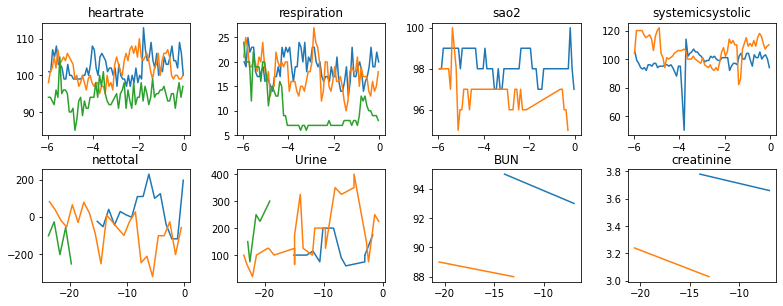

In [192]:
pid = list(pid_5849.keys())[1300]
patient_info, patient_data = load_processed_patient_data_by_id(pid)

dx_list = patient_data[patient_data['UID']>7e5]

dx_target_list = dx_list[dx_list['UID']==dx_target_uid]

nrows, ncols = 2, 4
dx_fig, dy_fig = 1.5, 1
figsize = plt.figaspect(float(dy_fig * nrows) / float(dx_fig * ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
fig.tight_layout()
pad = 0.05 # Padding around the edge of the figure
xpad, ypad = dx_fig * pad, dy_fig * pad
fig.subplots_adjust(left=xpad, right=1-xpad, top=1-ypad, bottom=ypad)
fig.set_title(f'Patient {pid}: {dx_target} at ')

for i in range(dx_target_list.shape[0]):
    dx =  dx_target_list.iloc[i]
    ts = dx['Offset']
#     if dx['Value'] != 1:
#         continue
    if ts < 360:
        continue
#     print(dx['UID'], ts)
    ts_prev = dx_list[dx_list['Offset']<ts]
    if (ts_prev.shape[0] == 0) or (ts - ts_prev['Offset'].iloc[-1]) >= 600:
        for si, sig in enumerate(SELECTED_SIGNALS):
            uid = uid_dict[sig]
            sig_data = sig_exist(uid, patient_data, ts, SIGNAL_WINDOW_SIZE[sig])
            
            irow = si // 4
            icol = si % 4
            axs[irow][icol].plot((sig_data['Offset']-ts)/60, sig_data['Value'])
            axs[irow][icol].set_title(sig)

#             if sig_data.empty:
#                 print(sig, 0)
#             else:
#                 print(sig, 1)
#     print('prev. dx: ', ts_prev['Offset'].iloc[-1])


# Save data plot for each patient

In [8]:
for pid in pid_5849:
    # create plots
    nrows, ncols = 2, 4
    dx_fig, dy_fig = 1.5, 1
    figsize = plt.figaspect(float(dy_fig * nrows) / float(dx_fig * ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, dpi=300)
    fig.tight_layout()
    pad = 0.05 # Padding around the edge of the figure
    xpad, ypad = dx_fig * pad, dy_fig * pad
    fig.subplots_adjust(left=xpad, right=1-xpad, top=1-ypad, bottom=ypad)

    
    patient_info, patient_data = load_processed_patient_data_by_id(pid)
    dx_list = patient_data[patient_data['UID']>7e5]
    dx_target_list = dx_list[dx_list['UID']==dx_target_uid]
    
    for i in range(dx_target_list.shape[0]):
        dx =  dx_target_list.iloc[i]
        ts = dx['Offset']
        if dx['Value'] != 1:
            continue
        if ts < 360:
            continue
    #     print(dx['UID'], ts)
        ts_prev = dx_list[dx_list['Offset']<ts]
        if (ts_prev.shape[0] == 0) or (ts - ts_prev['Offset'].iloc[-1]) >= 600:
            for si, sig in enumerate(SELECTED_SIGNALS):
                uid = uid_dict[sig]
                sig_data = sig_exist(uid, patient_data, ts, SIGNAL_WINDOW_SIZE[sig])

                irow = si // 4
                icol = si % 4
                axs[irow][icol].plot((sig_data['Offset']-ts)/60, sig_data['Value'])
                axs[irow][icol].set_title(sig)
                axs[irow][icol].grid()
                
            save_file = str(pid)+'.png'
            fig.savefig('processed/acute_renal_failure/patient_data_plots/'+save_file)
    fig.clf()
    plt.close('all')
    plt.close(fig)